In [29]:
# For matrix calculation
import cv2
import numpy as np
import os

# For visualization
import matplotlib.pylab as plt
%matplotlib inline

# Random number generator
import random

In [8]:
# Load the training_data.npy numpy file
# This file includes our data which we collected before. Every folder has own training_data.npy
# PATH is data folder we want to train
# Only change the PATH
PATH='../deep_learning/data/004/'
data = np.load(PATH+'training_data.npy')

In [9]:
# Checking if we correctly load the file
data[1]

array(['00001.jpg', '0.0', '0.0'], dtype='<U21')

In [10]:
# Another checking
data[20:30]

array([['00020.jpg', '0.8742060661315918', '0.0'],
       ['00021.jpg', '0.890174388885498', '0.0'],
       ['00022.jpg', '0.890174388885498', '0.0'],
       ['00023.jpg', '0.890174388885498', '0.0'],
       ['00024.jpg', '0.890174388885498', '0.0'],
       ['00025.jpg', '0.890174388885498', '0.0'],
       ['00026.jpg', '0.890174388885498', '0.0'],
       ['00027.jpg', '0.890174388885498', '0.0'],
       ['00028.jpg', '0.890174388885498', '0.0'],
       ['00029.jpg', '0.890174388885498', '0.0']], dtype='<U21')

In [11]:
# Total number of data
len(data)

88

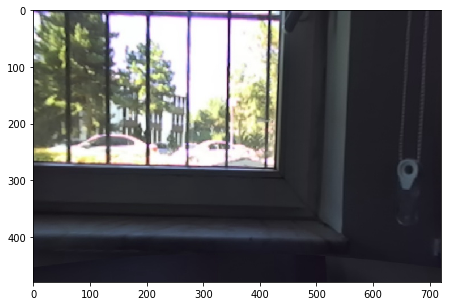

In [12]:
# visualize any image in the data set
from PIL import Image
# It should be lower than the total number of images which shown in the upper cell
IMAGE = 30
image = Image.open(PATH+data[IMAGE][0])
plt.figure(figsize=(15,5))
plt.imshow(image)

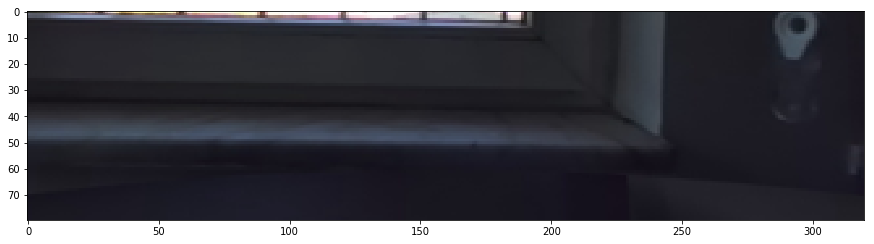

In [13]:
# Cropping the image from the top is useful for training as it will remove irrelevant data
image = np.asarray(image.resize((320, 180), Image.ANTIALIAS))
plt.figure(figsize=(15,5))
CROP = 100
plt.imshow(image[CROP:,:,:]) #Cropped image 

In [14]:
# we assign the image paths and the corresponding labels to two separate same size arrays
images = list(img[0] for img in data[1:])
labels = list(float(img[2]) for img in data[1:])

In [15]:
len(images)

87

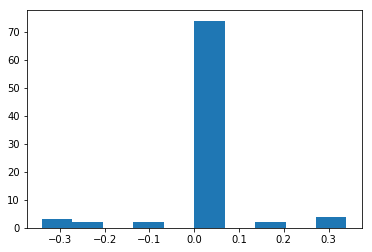

In [16]:
# the distribution of angles in our data
# Uneven distribution of the training leads to failure of training
plt.hist(labels)
plt.show()

# Augmentasyon işlemi

 Augmentasyon işlemini tamamladıktan sonra **model_trainer.py** dosyasında ilgili yere aşağıdaki kod bloğunu yapıştırın.

In [17]:
# In order to correct the angle distribution in the data set, 
# we try to re-add the number of angle records to the list.
# In other words augmentation
nitem = len(images)
for i in range(nitem):
    if labels[i] > 0.05:
        for j in range(7):
            images.append(images[i])
            labels.append(labels[i])    
    if labels[i] < -0.07:
        for j in range(2):
            images.append(images[i])
            labels.append(labels[i]) 

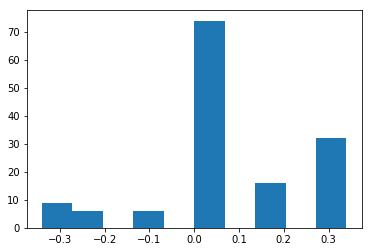

In [18]:
# İlk histgorama göre daga dengeli sayılabilecek bir dağılıma ulaştık
# En doğru çözüm değil ama pratik işe yarar bir alternatif
plt.hist(labels)
plt.show()

In [19]:
len(images), len(labels)

(143, 143)

In [20]:


# Veri setimiz ile ilgili ayarlamalar
# Veri seti küme büyüklüğü batch size
# Verisetinin ne kadarı eğitim ne kadarı test için kullanılacak
# Eğitim %80 , Test %20 
bsize = 8
dlen = len(labels)
splitpoint = int(0.8*dlen)
reindex = list(range(len(labels)))
# Eğtim verisini karıştıryoruz
random.seed(1234)
random.shuffle(reindex)



In [21]:

# Resim üzerinde Rastgele parlaklık değişimi uygulayan bir fonksiyon
# Augmentation function (taken from github)
def augment_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_BGR2HSV) 
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1


# In[ ]:


# ismi verilen resmi okuyup 
# rastgele olarak %50 sine parlaklık değişimi uygulayan fonksiyonu uygulayıp
# resim matrisini dönem bir fonksiyon

def get_matrix(fname):
    img = cv2.imread(PATH+fname)
    img = cv2.resize(img, (320,180))
    if random.randint(0,1) == 1 :
        img = augment_brightness(img)        
    return img[100:,:,:] # Return the cropped image, (320,80)



In [22]:
# Bütün veriyi hafızaya almamız mümkün değil
# Ek olarak bazen çeşitli değişimler - Augmentation - uygulamakda istiyebiliriz
# python generator ile gerektiğinde veri okunur düzenlenir ve eğitim veya test için 
# sisteme verilir
# alttaki fonksiyonlar bu işi yapar

# Generate data for training
def generate_data():
    i = 0
    while True:
        x = []
        y = []
        for j in range(i,i+bsize):  
            ix = reindex[j]
            img = get_matrix(images[ix])
            lbl = np.array([labels[ix]])
            flip = random.randint(0,1)
            if flip == 1:
                img = cv2.flip(img,1)
                lbl = lbl*-1.0
            x.append(img)
            y.append(lbl)
        x = np.array(x)
        y = np.array(y)       
        yield (x,y)    
        i +=bsize
        if i+bsize > splitpoint:
            i = 0
            
# Generate data for validation                  
def generate_data_val():
    i = splitpoint
    while True:
        x = []
        y = []
        for j in range(i,i+bsize): 
            ix = reindex[j]
            x.append(get_matrix(images[ix]))
            y.append(np.array([labels[ix]]))
        x = np.array(x)
        y = np.array(y)       
        yield (x,y)    
        i +=bsize
        if i+bsize > dlen:
            i = splitpoint

In [23]:
# Keras için gerekenler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D, Cropping2D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [24]:

# Model based on NVIDIA's End to End Learning for Self-Driving Cars model
# Sıralı bir keras modeli tanılıyoruz
model = Sequential()
# Normalization
# 0 - 255 arası değerler -1 ila 1 arasına çekiliyor
model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(80, 320, 3)))
# Evrişim katmanı (5, 5) lik 24 tane 2 şer piksel kayarak
model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
# Ağın çıkışı burda vectöre çevriliyor
model.add(Flatten())
# Yapay Sinir ağı kısmı
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
# Ağın çıkışı Açı 
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [25]:
# Tanımladığımız ağın yapsı
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 33, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 6336)             

In [26]:
# Açı değerlerinide -0.3 ila 0.3 aralığından -1 ila 1 aralığına çekebilmek için 3 ile çarpıyoruz
labels = 3*np.array(labels)

In [37]:
weights_path = os.environ['HOME'] + '/marc_models/'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)

In [38]:
# Eğitim esnasında test hata değeri en düşük değeri kaydeden bir fonksiyon
model_checkpoint = ModelCheckpoint(weights_path + 'model_new.h5', monitor='val_loss', save_best_only=True)

In [39]:
# Eğitim fonksiyonu 
hs = model.fit_generator(generate_data(),steps_per_epoch=int(splitpoint/ bsize),
                    validation_data=generate_data_val(), 
                    validation_steps=(dlen-splitpoint)/bsize, epochs=10,callbacks=[model_checkpoint])

Epoch 1/10
14/14 [==============================] - 1s 84ms/step - loss: 0.3161 - val_loss: 0.2819
Epoch 2/10
14/14 [==============================] - 1s 70ms/step - loss: 0.3108 - val_loss: 0.3798
Epoch 3/10
14/14 [==============================] - 1s 76ms/step - loss: 0.3273 - val_loss: 0.3149
Epoch 4/10
14/14 [==============================] - 1s 73ms/step - loss: 0.3242 - val_loss: 0.2912
Epoch 5/10
14/14 [==============================] - 1s 81ms/step - loss: 0.3153 - val_loss: 0.3334
Epoch 6/10
14/14 [==============================] - 1s 73ms/step - loss: 0.3368 - val_loss: 0.3297
Epoch 7/10
14/14 [==============================] - 1s 74ms/step - loss: 0.3110 - val_loss: 0.3293
Epoch 8/10
14/14 [==============================] - 1s 71ms/step - loss: 0.3324 - val_loss: 0.3411
Epoch 9/10
14/14 [==============================] - 1s 73ms/step - loss: 0.3151 - val_loss: 0.3005
Epoch 10/10
14/14 [==============================] - 1s 75ms/step - loss: 0.3025 - val_loss: 0.2358


In [40]:
# Eğittiğimiz modeli kaydediyoruz
# Ağ yapsını json olarak
# Ağ parametre değerlerini h5 uzantılı olarak
import json 
# Save model weights and json.
mname = 'model_new'
model.save_weights(weights_path + mname+'.h5')
model_json  = model.to_json()
with open(weights_path + mname +'.json', 'w') as outfile:
    json.dump(model_json, outfile)